## STEP 


In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Fri Mar 21 16:12:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P5              9W /   80W |     141MiB /   8188MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [4]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [5]:
from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.experimental.ONNXPolicyExporter import ONNXPolicyExporter


2025-03-21 16:13:04.415873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742587984.478694   10604 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742587984.495170   10604 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742587984.589204   10604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742587984.589284   10604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742587984.589287   10604 computation_placer.cc:177] computation placer alr

In [6]:
registry.locomotion.ALL_ENVS

('BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'StepJoystickFlatTerrain',
 'StepJoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'T1JoystickFlatTerrain',
 'T1JoystickRoughTerrain')

## STEP Bipedal

joystick policy on the Berkeley Humanoid. The initial policy takes 17 minutes to train on an RTX 4090.

In [7]:
from mujoco_playground.config import locomotion_params


# env_name = 'BerkeleyHumanoidJoystickFlatTerrain'
env_name = 'G1JoystickRoughTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

In [8]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

/home/zhiquancao/miniconda3/envs/playground/lib/python3.10/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


In [ ]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

env = registry.load(env_name)
eval_env = registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env.mj_model.body("torso").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )

render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

episode 0


KeyError: "Invalid name 'torso'. Valid names: ['FL_calf', 'FL_hip', 'FL_thigh', 'FR_calf', 'FR_hip', 'FR_thigh', 'RL_calf', 'RL_hip', 'RL_thigh', 'RR_calf', 'RR_hip', 'RR_thigh', 'trunk', 'world']"

### Inference from params

Checkpoint loaded and JAX inference_fn created from checkpoint.
TF Keras model built.
Transferring to layer hidden_0: kernel (42, 512), bias (512,)
Transferring to layer hidden_1: kernel (512, 256), bias (256,)
Transferring to layer hidden_2: kernel (256, 128), bias (128,)
Transferring to layer hidden_3: kernel (128, 24), bias (24,)
JAX weights transferred to the TF model successfully.
Exporting to ONNX: policy.onnx


I0000 00:00:1742586394.540949    3040 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1742586394.541577    3040 single_machine.cc:374] Starting new session
I0000 00:00:1742586394.542922    3040 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1924 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1742586394.631791    3040 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1924 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1742586394.644987    3040 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1742586394.645615    3040 single_machine.cc:374] Starting new session
I0000 00:00:1742586394.646543    3040 gpu_device.cc:2019] Created device /job:localhost/replic

ONNX file saved as policy.onnx

--- Comparison of outputs on dummy input ---
TF output:   [-0.602  0.955 -0.179 -0.897 -0.138 -0.374 -0.151  0.429  0.2    0.914  0.891  0.873]
ONNX output: [-0.602  0.955 -0.179 -0.897 -0.138 -0.374 -0.151  0.429  0.2    0.914  0.891  0.873]
JAX output:  [-0.602  0.955 -0.179 -0.897 -0.138 -0.374 -0.151  0.429  0.2    0.914  0.891  0.873]


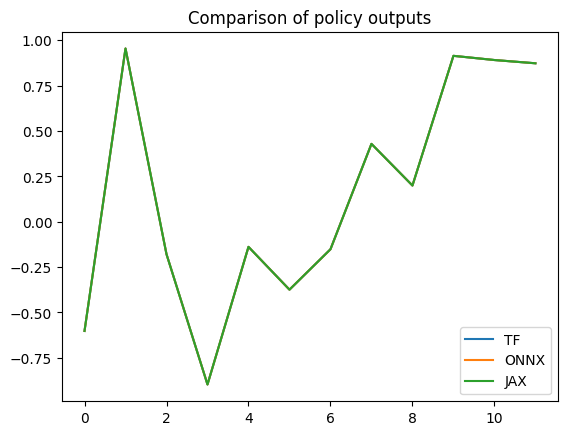

In [ ]:
exporter = ONNXPolicyExporter(env_name)
# exporter.set_inference_fn(jit_inference_fn)   # Provide your external JAX inference function
exporter.params = params                   # So you can still build TF model if it needs mean/std
exporter.load_checkpoint()
exporter.build_tf_model()
exporter.transfer_weights_jax_to_tf()
exporter.export_to_onnx()
exporter.compare_inference()

### Inference from reloaded params

In [ ]:
import pickle

with open("params.pkl", "wb") as f:
    pickle.dump(params, f)
    

Checkpoint loaded and JAX inference_fn created from checkpoint.
TF Keras model built.
Transferring to layer hidden_0: kernel (42, 512), bias (512,)
Transferring to layer hidden_1: kernel (512, 256), bias (256,)
Transferring to layer hidden_2: kernel (256, 128), bias (128,)
Transferring to layer hidden_3: kernel (128, 24), bias (24,)
JAX weights transferred to the TF model successfully.
Exporting to ONNX: policy.onnx


I0000 00:00:1742586210.527697    3040 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1742586210.527971    3040 single_machine.cc:374] Starting new session
I0000 00:00:1742586210.529373    3040 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1924 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1742586210.620988    3040 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1924 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1742586210.633989    3040 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1742586210.634734    3040 single_machine.cc:374] Starting new session
I0000 00:00:1742586210.636163    3040 gpu_device.cc:2019] Created device /job:localhost/replic

ONNX file saved as policy.onnx

--- Comparison of outputs on dummy input ---
TF output:   [-0.602  0.955 -0.179 -0.897 -0.138 -0.374 -0.151  0.429  0.2    0.914  0.891  0.873]
ONNX output: [-0.602  0.955 -0.179 -0.897 -0.138 -0.374 -0.151  0.429  0.2    0.914  0.891  0.873]
JAX output:  [-0.602  0.955 -0.179 -0.897 -0.138 -0.374 -0.151  0.429  0.2    0.914  0.891  0.873]


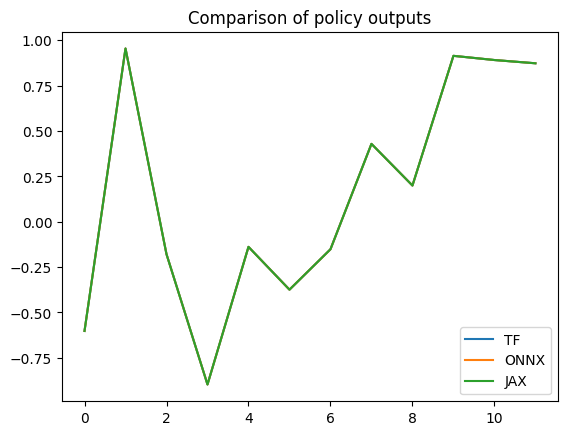

In [ ]:
with open("params.pkl", "rb") as f:
    loaded_params = pickle.load(f)
    
loaded_exporter = ONNXPolicyExporter(env_name)
loaded_exporter.params = loaded_params
loaded_exporter.load_checkpoint()
loaded_exporter.build_tf_model()
loaded_exporter.transfer_weights_jax_to_tf()
loaded_exporter.export_to_onnx()
loaded_exporter.compare_inference()